# LAB

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
from keras.datasets import mnist
import numpy as np
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

## 1. Proszę zademonstrować uczenie typu CD (Contrastive Divergence) pisząc procedury przejścia pomiędzy warstwą "wizualną" i ukrytą w sieci RBM. Następnie użyć tego mechanizmu do wyuczenia reprezentacji ukrytej z danych i wykorzystać tę reprezentację do przewidzenia wartości "wizualnej". Tego typu system nadaje się dobrze do tworzenia rekomendacji tj. znajdowania powiązań typu użytkownik-produkt zwiedzy o cząstkowych wyborach różnych produktów przez różnych użytkowników.

## 2. Use RBM web ( own or use made from API scikit-learn) on some simple dataset (Mnist, Fashion Mnist, etc.) to:
-   show feature representation from CD learning
-   generate random examples
https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist
https://www.pyimagesearch.com/2014/06/23/applying-deep-learning-rbm-mnist-using-python/
https://www.kaggle.com/amitmeel1/restricted-bolztmann-machine-rbm/notebook

In [4]:
def load_digits(dataset_path: str) -> tuple:
	X = np.genfromtxt(dataset_path, delimiter = ",", dtype = "uint8")
	y = X[:, 0]
	X = X[:, 1:]
	return X, y

The BernoulliRBM assumes that the columns of our feature vectors fall within the range [0, 1].
However, the MNIST dataset is represented as unsigned 8-bit integers, falling within the range [0, 255].

To scale the columns into the range [0, 1], all we need to do is define a scale function:

In [5]:
def scale(x, eps = 0.001):
	return (x - np.min(x, axis = 0)) / (np.max(x, axis = 0) + eps)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


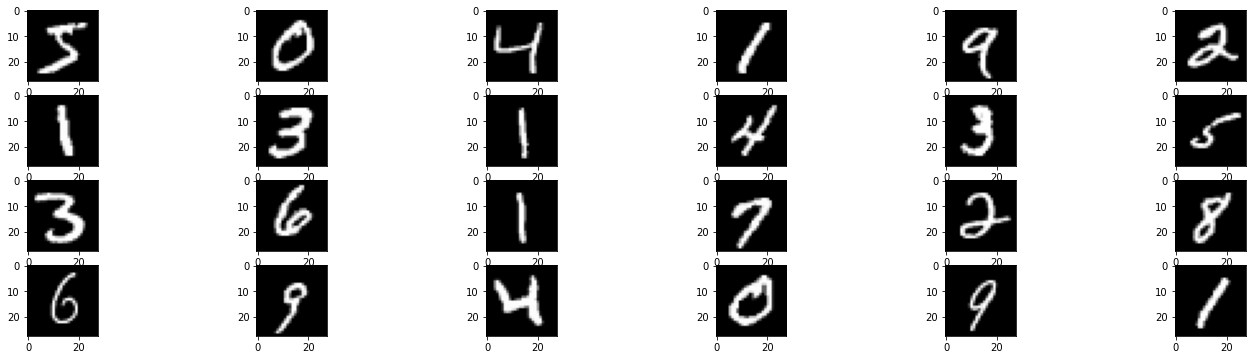

In [20]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
fig, axs = plt.subplots(4, 6, figsize=(24, 6))
row = 0
for i in range(24):
    index = i % 6
    axs[row][index].imshow(train_X[i], cmap=plt.get_cmap('gray'))
    if index == 5:
        row = row + 1
plt.show()

In [48]:
train_X = train_X.astype("float32")
train_X = scale(train_X)
test_X = test_X.astype("float32")
test_X = scale(test_X)

In [49]:
nsamples, nx, ny = train_X.shape
train_X = train_X.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_X.shape
test_X = test_X.reshape((nsamples,nx*ny))

In [71]:
class SimpleRBM:
    """A simple RBM example"""
    def __init__(self, iterations: int, lr0: float, components: int, verbose: bool = True):
        self.iterations = iterations
        self.lr0 = lr0
        self.components = components
        self.classifier = None
        self.verbose = verbose

    def train(self, train_x: np.ndarray, train_y: np.ndarray) -> None:
        self.classifier = BernoulliRBM(n_components = self.components, n_iter = self.iterations, learning_rate = self.lr0,  verbose = self.verbose)
        self.classifier.fit(train_x, train_y)

    def print_report(self, test_x: np.ndarray, test_y: np.ndarray) -> None:
        print(classification_report(test_y, self.classifier.predict(test_x)))

    def print_features(self) -> None:
        plt.figure(figsize=(20, 20))
        for i, comp in enumerate(self.classifier.components_):
            plt.subplot(10, 10, i + 1)
            plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu, interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
            plt.suptitle('100 components extracted by RBM', fontsize=16)
        plt.show()

In [79]:
plt.rcParams['image.cmap'] = 'gray'

lr0 = 0.01
iterations = 100
components = 100

In [80]:
simpleRBM = SimpleRBM(iterations=iterations, lr0=lr0, components=components, verbose=True)

In [81]:
simpleRBM.train(train_X, train_y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -112.42, time = 8.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -99.19, time = 9.67s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -93.19, time = 9.32s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -90.58, time = 8.43s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -87.62, time = 9.48s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -84.08, time = 9.78s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -83.70, time = 8.83s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -81.24, time = 9.16s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -81.58, time = 8.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -79.81, time = 8.27s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -79.23, time = 7.92s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -81.81, time = 7.91s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -79.04, time = 7.93s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -78.66, time = 7.91s
[BernoulliRBM] Iteration 15,

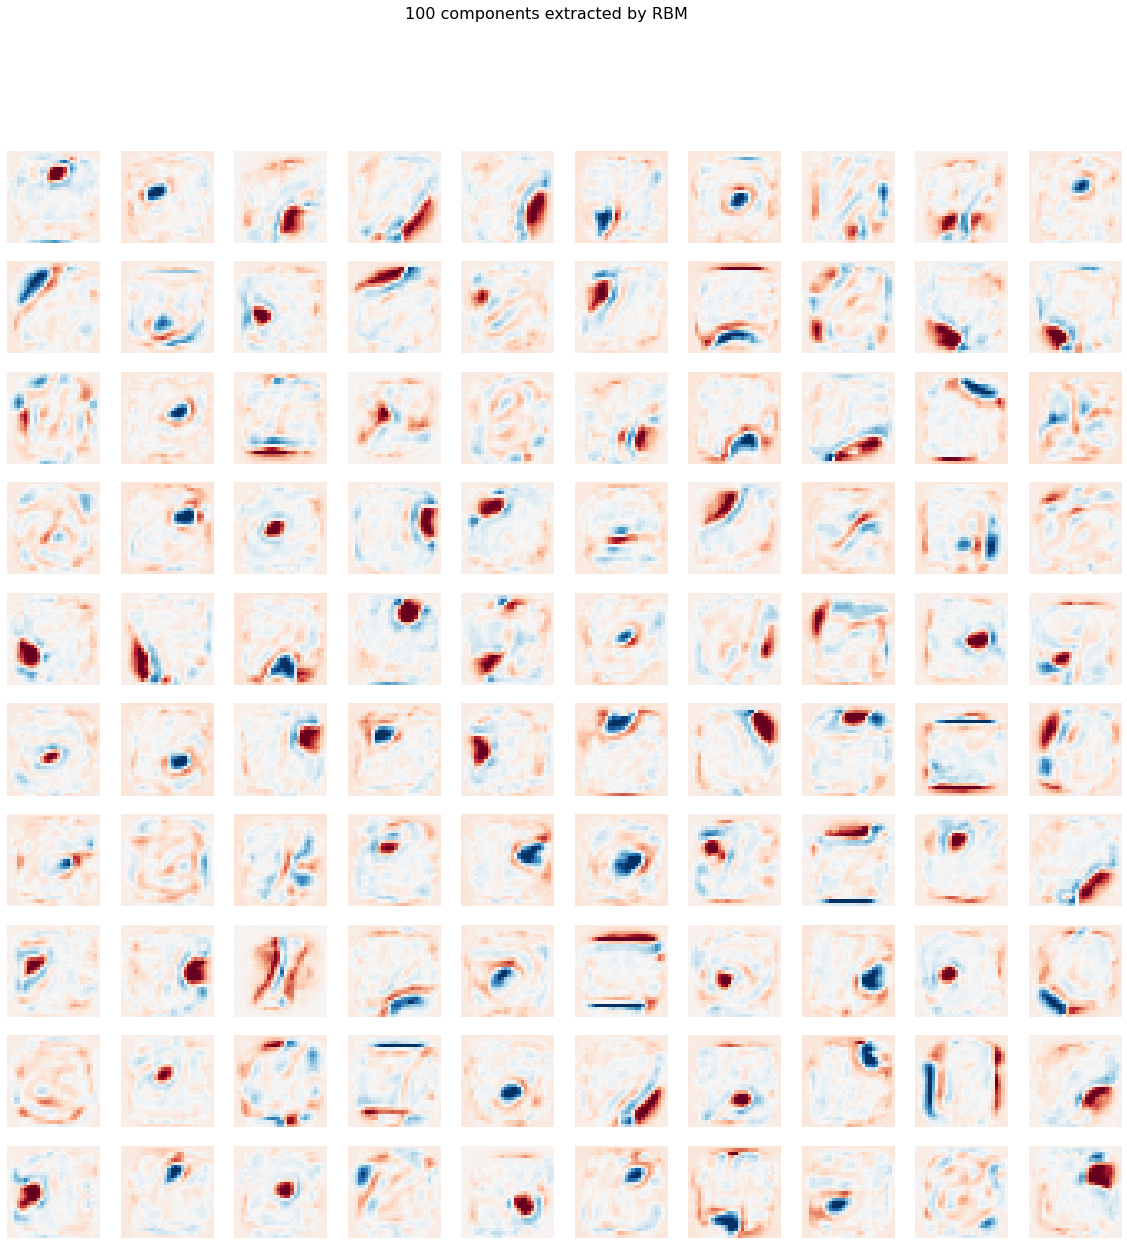

In [82]:
simpleRBM.print_features()

In [77]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

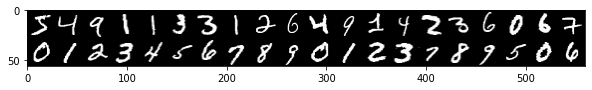

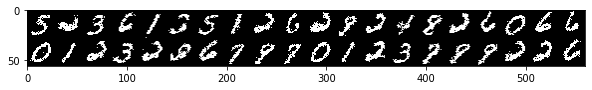

In [85]:
xx = train_X[:40].copy()
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))
plt.show()

#for ii in range(10000):
for ii in range(100):
    for n in range(40):
        xx[n] = simpleRBM.classifier.gibbs(xx[n])
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))
plt.show()


## 3. Use any working DBN web (architecture, learning and example of problem to solve)